In [1]:
# Crypto heatmap

In [2]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
plt.style.use('ggplot')
%matplotlib inline

In [3]:
url = "https://min-api.cryptocompare.com/data/histoday?fsym=BTC&tsym=USD&limit=10&e=Coinbase"
f = requests.get(url)
ipdata = f.json()
pd.DataFrame(ipdata['Data']).head(5)

,time,close,high,low,open,volumefrom,volumeto
0,1576800000,7190.00,7220.00,7073.66,7149.12,6019.75,4.306225e+07
1,1576886400,7143.01,7190.00,7099.57,7190.00,3385.22,2.418772e+07
2,1576972800,7513.06,7521.55,7125.00,7143.01,9719.68,7.122701e+07
3,1577059200,7310.79,7688.99,7259.19,7513.06,14577.19,1.094814e+08
4,1577145600,7255.01,7426.15,7151.08,7310.79,7730.62,5.635461e+07


In [4]:
def get_data(date):
    """query API for 2000 days historical price data starting from "date"."""
    url = "https://min-api.cryptocompare.com/data/histoday?fsym=BTC&tsym=USD&limit=2000&toTs={}".format(
        date)
    r = requests.get(url)
    ipdata = r.json()
    return ipdata

In [5]:
def get_df(from_date, to_date):
    date = to_date
    holder = []
    # while earliest date returned is later than the earliest data requested, keep querying API # and adding results to list
    while date > from_date:
        data = get_data(date)
        holder.append(pd.DataFrame(data['Data']))
        date = data['TimeFrom']
        # join together all api queries from list
        df = pd.concat(holder, axis=0)
        # remove data points from before from_date
        df = df[df['time'] > from_date]
        # convert to timestamp
        df['time'] = pd.to_datetime(df['time'], unit='s')
        # make datafrom index the time
        df.set_index('time', inplace=True)
        # sort in time order
        df.sort_index(ascending=False, inplace=True)
        return df

In [6]:
df = get_df(1575158400, 1577731535)

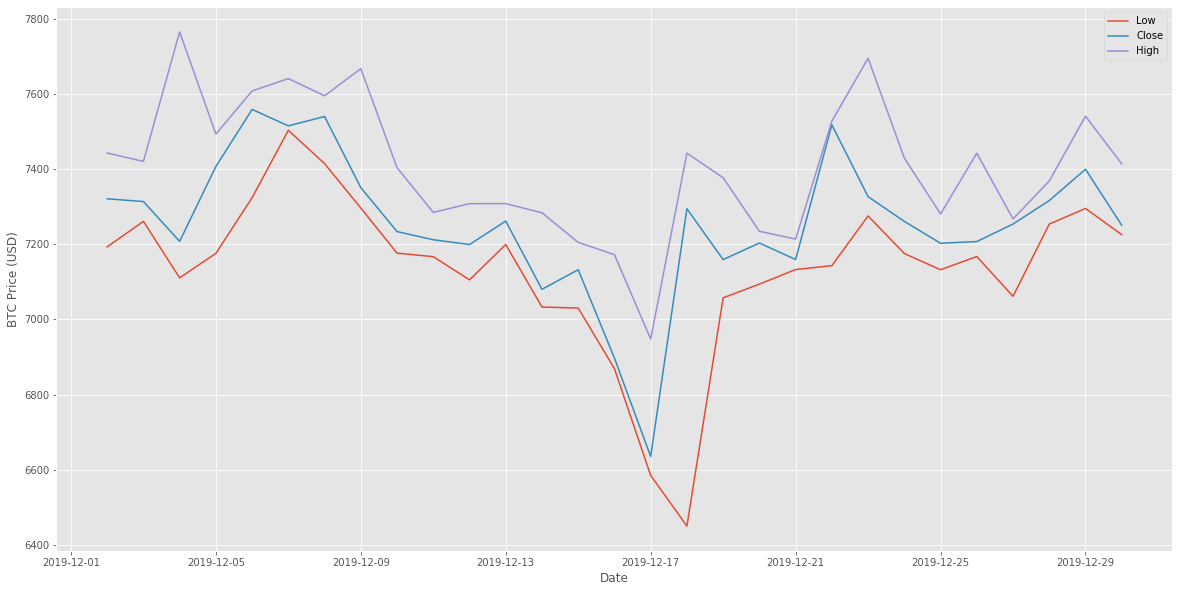

In [7]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(df[['low', 'close', 'high']])
ax.set_ylabel('BTC Price (USD)')
ax.set_xlabel('Date')
ax.legend(['Low', 'Close', 'High'])
plt.show();

In [8]:
def get_data_spec(coin, date, time_period):
    """query api for historical data starting from "date"."""
    url = "https://min-api.cryptocompare.com/data/{}?fsym={}&tsym=USD&Limit=2000&toTs={}".format(
        time_period, coin, date)
    r = requests.get(url)
    ipdata = r.json()
    return ipdata

In [9]:
def get_df_spec(time_period, coin, from_date, to_date):
    """ get historical price data between dates. If further apart query multiple times."""
    date = to_date
    holder = []
    while date > from_date:
        data = get_data_spec(coin, date, time_period)
        holder.append(pd.DataFrame(data['Data']))
        date = data['TimeFrom']
    df = pd.concat(holder, axis=0)
    df = df[df['time'] > from_date]
    df['time'] = pd.to_datetime(df['time'], unit='s')
    df.set_index('time', inplace=True)
    df.sort_index(ascending=False, inplace=True)
    df.rename(columns={'close': coin}, inplace=True)
    return df[coin]

In [10]:
coins = ['BTC', 'ETH', 'LTC', 'DOGE']

In [11]:
holder = []
from_date = 1575158400  # 12-01-2019
to_date = 1577731535 # Today 
time_period = 'histoday'
for coin in coins:
    holder.append(get_df_spec(time_period, coin, from_date, to_date))
df = pd.concat(holder, axis=1)

In [12]:
# convert each column of df to be rate of return instead of price
df = df.divide(df.shift()) - 1
df_norm_col = (df - df.mean()) / df.std()

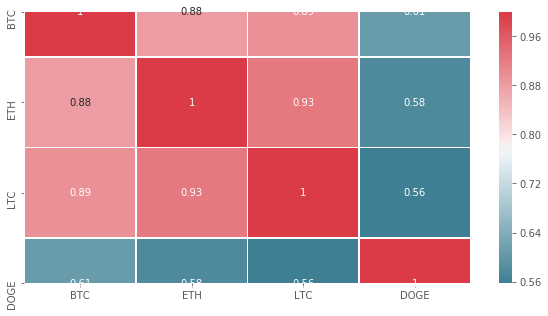

In [13]:
fig = plt.figure(figsize=(10, 5))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(df.corr(), annot=True, linewidth=0.5, cmap=cmap)
plt.show();